<a href="https://colab.research.google.com/github/iqbals/introtodeeplearning/blob/master/Active_Learning_Tutorial_for_CDoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning Tutorial

This notebook is available at [broad.io/pyro-cdot-notebook](http://broad.io/pyro-cdot-notebook).
See also [introductory slides](https://docs.google.com/presentation/d/1LqNbAGJ3xmUZx9OCWXJlzHwvJLppCrn5Jd6OuxswM5A/edit?usp=sharing).

Note this is a demo/simulation, we'll start with a fully-tested dataset, then "reveal" labels to simulate lab work.

First we'll install Pyro and import Pyro and PyTorch.  This notebook can run on either CPU or GPU (runtime --> change runtime type). You can also run locally by starting a jupyter server locally.

In [ ]:
!pip install -q pyro-ppl
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import ClippedAdam
from pyro.nn.module import to_pyro_module_, PyroSample
from pyro import poutine
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("using GPU")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    print("using CPU")

using CPU


## Load dataset #1

We've stored both this notebook and our input data in Google Drive, that way everyone who has access to the data has access to this notebook.

To run this, you'll need to click the link, authorize colab in another tab, copy the auth token, close that other tab, and paste the auth token back here.

In [ ]:
!pip install -q pydrive2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 3.5 MB 11.8 MB/s 


In [ ]:
# Download files from Google Drive to the notebook runtime.
filename_to_id = {
    "positives.csv": "1iZ5mC7p2HkdUXs5-H2N2bHCUdb6vLb-I",
    "negatives.csv": "1tTvVuKiI5yqanAbOvfcp39fstjnPcyga",
}
for filename, drive_id in filename_to_id.items():
    drive.CreateFile({"id": drive_id}).GetContentFile(filename)

In [ ]:
import pandas as pd
pos_df = pd.read_csv("positives.csv", header=None)
neg_df = pd.read_csv("negatives.csv", header=None)
pos_df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,CNC(=O)[C@@H](Cc1ccncc1)NC(=O)c2cccc(C3CCCN(C(...,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,CNC(=O)CNC(=O)c1cccc(C2CCCN(C(=O)Cc3cccc(CNS(=...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,CNC(=O)C[C@H](NC(=O)c1cccc(C2CCCN(C(=O)CNS(=O)...,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,CNC(=O)C1c2ccccc2CN1C(=O)c3cccc(C4CCN(C(=O)CNS...,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,CNC(=O)C[C@H](NC(=O)c1cccc(C2CCN(C(=O)CNS(=O)(...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CNC(=O)c1cc(NC(=O)C=Cc2ccnc3c(Cl)cccc23)ccc1-c...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4996,CNC(=O)c1cc(NC(=O)C=Cc2ccnc3c(Cl)cccc23)ccc1-c...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4997,CNC(=O)c1cc(NC(=O)C=Cc2ccnc3c(Cl)cccc23)ccc1-c...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4998,CNC(=O)c1cccc(NC(=O)C=Cc2ccc3cc(Br)ccc3n2)c1-c...,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Convert dataframes to PyTorch.

In [ ]:
pos_features = torch.tensor(pos_df[list(range(1, 1025))].to_numpy(), dtype=torch.float)
neg_features = torch.tensor(neg_df[list(range(1, 1025))].to_numpy(), dtype=torch.float)
print(pos_features.shape, neg_features.shape)

torch.Size([5000, 1024]) torch.Size([10000, 1024])


Merge positive and negative data.

In [ ]:
features = torch.cat([pos_features, neg_features], 0)
true_labels = torch.cat([torch.ones(len(pos_features)), torch.zeros(len(neg_features))])

Randomly shuffle data for our simulated experiment.

In [ ]:
torch.manual_seed(20211014)
perm = torch.randperm(len(features))

features = features[perm]
true_labels = true_labels[perm]

## Set up an active learning experiment.

In [ ]:
print(features.shape, true_labels.shape)

torch.Size([15000, 1024]) torch.Size([15000])


In [ ]:
def reveal_labels(ids):
    "Simulates obtaining labels from a lab experiment."
    return true_labels[ids]

Create an initial batch of data arbitrarily, and test this.

In [ ]:
batch = {}
batch["ids"] = torch.arange(1000)  # arbitrary
batch["features"] = features[batch["ids"]]
batch["labels"] = reveal_labels(batch["ids"])
initial_batch = batch

We'll define three simple classification models that we'll train at each step of active learning. The first model is a naive random baseline model.

In [ ]:
class RandomModel:
    def fit(self, features, labels, **kwargs):
        pass

    def predict_logits(self, features):
        return torch.randn(features.shape[:-1])

The second model is a greedy neural network model.

In [ ]:
class GreedyMLP(pyro.nn.PyroModule):
    def __init__(self, layer_sizes=[1024, 128, 1]):
        super().__init__()
        layers = []
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(torch.nn.Linear(in_size, out_size))
            layers.append(torch.nn.Sigmoid())
        layers.pop(-1)
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, features, labels, subsample_size=None):
        self.mlp[-1].weight  # triggers pyro.sample before the plate
        with pyro.plate("molecules", len(features), subsample_size) as batch:
            logits = self.mlp(features[batch]).squeeze(-1)
            pyro.sample("labels", dist.Bernoulli(logits=logits), obs=labels[batch])

    def fit(self, features, labels, *,
            lr=1e-2, num_steps=10001, log_every=1000, batch_size=64):
        def guide(*args, **kwargs):
            pass
        pyro.clear_param_store()
        optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / num_steps)})
        elbo = JitTrace_ELBO(ignore_jit_warnings=True)
        svi = SVI(self, guide, optim, elbo)
        losses = []
        for step in range(num_steps):
            loss = svi.step(features, labels, subsample_size=batch_size)
            loss /= len(labels)
            losses.append(loss)
            if log_every and step % log_every == 0:
                print(f"step {step} loss = {loss:0.6g}")
        return losses

    @torch.no_grad()
    def predict_logits(self, features):
        return self.mlp(features).squeeze(-1)

The third model uses a Bayesian neural network to balance exploration and exploitation.

In [ ]:
class ExploratoryMLP(GreedyMLP):
    def fit(self, features, labels, *,
            lr=1e-2, num_steps=10001, log_every=1000, batch_size=64):
        # First fit self as a maximum likelihood neural network.
        losses = super().fit(
            features, labels, lr=lr,
            num_steps=num_steps, log_every=log_every, batch_size=batch_size
        )

        # Then convert self in-place to a Bayesian neural network.
        to_pyro_module_(self.mlp)
        weight = self.mlp[-1].weight.data
        self.mlp[-1].weight = PyroSample(dist.Normal(weight, 1).to_event(2))
        
        # Then retrain.
        guide = AutoLowRankMultivariateNormal(self, init_scale=0.01)
        optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / num_steps)})
        elbo = JitTrace_ELBO(ignore_jit_warnings=True)
        svi = SVI(self, guide, optim, elbo)
        for step in range(num_steps):
            loss = svi.step(features, labels, subsample_size=batch_size)
            loss /= len(labels)
            losses.append(loss)
            if log_every and step % log_every == 0:
                print(f"step {step} loss = {loss:0.6g}")
        self.guide = [guide]  # cannot save as attribute
        return losses

    @torch.no_grad()
    def predict_logits(self, features):
        with poutine.condition(data=self.guide[0]()):
            return self.mlp(features).squeeze(-1)

### Sanity check the model architecture on full data
You wouldn't be able to validate predictive performance on real data since you wouldn't yet have ground truth labels. However architecture choice should probably transfer well across datasets, so you could determine model architecture based on a previous experiment and use that same architecture in a new experiment.

In [ ]:
%%time
model = GreedyMLP()
losses = model.fit(features, true_labels, num_steps=1001, log_every=100)

NameError: ignored

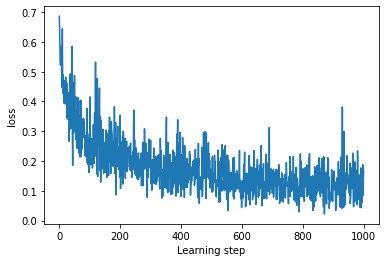

In [ ]:
plt.plot(losses)
plt.xlabel("Learning step")
plt.ylabel("loss");

In [ ]:
%%time
model = ExploratoryMLP()
losses = model.fit(features, true_labels, num_steps=1001, log_every=100)

step 0 loss = 0.593856
step 100 loss = 0.246935
step 200 loss = 0.205003
step 300 loss = 0.205676
step 400 loss = 0.132336
step 500 loss = 0.0726226
step 600 loss = 0.0943233
step 700 loss = 0.0569914
step 800 loss = 0.119287
step 900 loss = 0.108528
step 1000 loss = 0.123031
step 0 loss = 0.180278
step 100 loss = 0.0891203
step 200 loss = 0.141001
step 300 loss = 0.0724814
step 400 loss = 0.0371148
step 500 loss = 0.222037
step 600 loss = 0.120758
step 700 loss = 0.039288
step 800 loss = 0.0629113
step 900 loss = 0.148381
step 1000 loss = 0.037696
CPU times: user 17.1 s, sys: 185 ms, total: 17.3 s
Wall time: 17.4 s


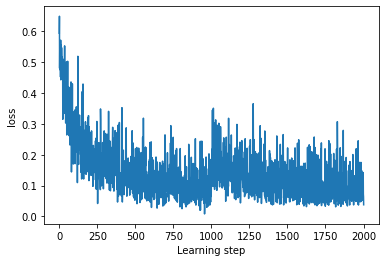

In [ ]:
plt.plot(losses)
plt.xlabel("Learning step")
plt.ylabel("loss");

### What happens at each step of active learning?

In [ ]:
def active_learning_step(
    batches, *,
    batch_size=1000,
    thompson_batch_size=None,
    measure_labels=reveal_labels,  # You could replace this with email_your_labmate.
    Model=RandomModel,
    num_steps=10001,
    log_every=1000,
):
    # Fit a model on previously observed molecules.
    past_features = torch.cat([b["features"] for b in batches])
    past_labels = torch.cat([b["labels"] for b in batches])
    past_ids = torch.cat([b["ids"] for b in batches])
    model = Model()
    model.fit(past_features, past_labels, num_steps=num_steps, log_every=log_every)

    # Pick the most promising molecules for the next batch.
    past_id_set = set(past_ids.tolist())  # Avoid re-measuring molecules.
    future_id_set = set(range(len(features))) - past_id_set
    if thompson_batch_size is None:
        # This is the simple greedy workflow.
        future_ids = torch.tensor(sorted(future_id_set))
        future_logits = model.predict_logits(features[future_ids])
        batch_ids = future_ids[future_logits.topk(batch_size, dim=0).indices]
    else:
        # This is the more complex exploratory workflow.
        batch_id_set = set()
        while len(batch_id_set) < batch_size:
            future_ids = torch.tensor(sorted(future_id_set))
            future_logits = model.predict_logits(features[future_ids])
            future_ids = future_ids[future_logits.sort(0).indices]
            future_ids = [i for i in future_ids.tolist() if i not in batch_id_set]
            batch_id_set.update(future_ids[:thompson_batch_size])
            future_id_set -= batch_id_set
            print(".", end="", flush=True)
        batch_ids = torch.tensor(sorted(batch_id_set))

    batch = {}
    batch["ids"] = batch_ids
    batch["features"] = features[batch["ids"]]
    batch["labels"] = measure_labels(batch["ids"])
    batches.append(batch)

    # Evaluate active learning performance.
    num_positives = sum(int(b["labels"].sum()) for b in batches)
    return num_positives

In [ ]:
%%time
batches = [initial_batch]
active_learning_step(batches, Model=RandomModel)

CPU times: user 52.1 ms, sys: 49.4 ms, total: 102 ms
Wall time: 32.8 ms


658

In [ ]:
%%time
batches = [initial_batch]
active_learning_step(batches, Model=GreedyMLP)

step 0 loss = 0.685415
step 1000 loss = 0.000181537
step 2000 loss = 5.47972e-05
step 3000 loss = 1.81744e-05
step 4000 loss = 1.61131e-05
step 5000 loss = 1.14065e-05
step 6000 loss = 4.67514e-06
step 7000 loss = 5.26189e-06
step 8000 loss = 2.05448e-06
step 9000 loss = 2.35251e-06
step 10000 loss = 1.43982e-06
CPU times: user 20.7 s, sys: 3.46 s, total: 24.2 s
Wall time: 19 s


1246

In [ ]:
%%time
batches = [initial_batch]
active_learning_step(batches, Model=ExploratoryMLP, thompson_batch_size=100)

step 0 loss = 0.691863
step 1000 loss = 0.000298541
step 2000 loss = 6.09516e-05
step 3000 loss = 1.98687e-05
step 4000 loss = 8.6685e-06
step 5000 loss = 1.37028e-05
step 6000 loss = 5.65487e-06
step 7000 loss = 4.45535e-06
step 8000 loss = 3.56508e-06
step 9000 loss = 2.5369e-06
step 10000 loss = 1.41374e-06
step 0 loss = 0.56052
step 1000 loss = 0.0231718
step 2000 loss = 0.00932072
step 3000 loss = 0.000910537
step 4000 loss = 0.00437164
step 5000 loss = 0.00404022
step 6000 loss = 0.00203424
step 7000 loss = 0.00299772
step 8000 loss = -0.000559902
step 9000 loss = 0.000567499
step 10000 loss = -0.0029893
..........CPU times: user 1min 8s, sys: 7.33 s, total: 1min 15s
Wall time: 1min 2s


337

In [ ]:
def active_learn(
    Model=RandomModel,
    batch_size=1000,
    num_batches=None,
    thompson_batch_size=None,
    log_every=0,
):
    # Create an initial batch.
    batch = {}
    batch["ids"] = torch.arange(batch_size)  # arbitrarily pick the first molecules
    batch["features"] = features[batch["ids"]]
    batch["labels"] = reveal_labels(batch["ids"])
    batches = [batch]
    num_positives = sum(int(b["labels"].sum()) for b in batches)
    print(f"Found {num_positives} positives")

    # Run active learning until all molecules are measured.
    for i in range(1, num_batches):
        active_learning_step(
            batches, batch_size=batch_size, Model=Model,
            thompson_batch_size=thompson_batch_size, log_every=log_every,
        )
        num_positives = sum(int(b["labels"].sum()) for b in batches)
        print(f"Found {num_positives} positives")
    return batches

In [ ]:
random_batches = active_learn(RandomModel, batch_size=1000, num_batches=15)

Found 335 positives
Found 662 positives
Found 999 positives
Found 1327 positives
Found 1666 positives
Found 2006 positives
Found 2324 positives
Found 2648 positives
Found 2999 positives
Found 3347 positives
Found 3689 positives
Found 4004 positives
Found 4344 positives
Found 4653 positives
Found 5000 positives


In [ ]:
%%time
greedy_batches = active_learn(GreedyMLP, batch_size=1000, num_batches=15)

Found 335 positives
Found 1249 positives
Found 2181 positives
Found 3087 positives
Found 3846 positives
Found 4378 positives
Found 4728 positives
Found 4899 positives
Found 4967 positives
Found 4987 positives
Found 4991 positives
Found 5000 positives
Found 5000 positives
Found 5000 positives
Found 5000 positives
CPU times: user 4min 46s, sys: 46.6 s, total: 5min 33s
Wall time: 4min 17s


In [ ]:
%%time
exploratory_batches = active_learn(ExploratoryMLP, batch_size=1000, num_batches=15)

Found 335 positives
Found 1228 positives
Found 2149 positives
Found 3048 positives
Found 3828 positives
Found 4400 positives
Found 4724 positives
Found 4898 positives
Found 4961 positives
Found 4987 positives
Found 4992 positives
Found 4999 positives
Found 5000 positives
Found 5000 positives
Found 5000 positives
CPU times: user 12min 35s, sys: 1min 35s, total: 14min 11s
Wall time: 11min 28s


In [ ]:
def plot_comparisons(**labeled_batches):
    for label, batches in labeled_batches.items():
        X = [0]
        Y = [0]
        for batch in batches:
            X.append(X[-1] + len(batch["labels"]))
            Y.append(Y[-1] + int(batch["labels"].sum()))
        plt.plot(X, Y, label=label)
    plt.xlabel("# molecules tested")
    plt.ylabel("# positive hits")
    plt.legend(loc="best")

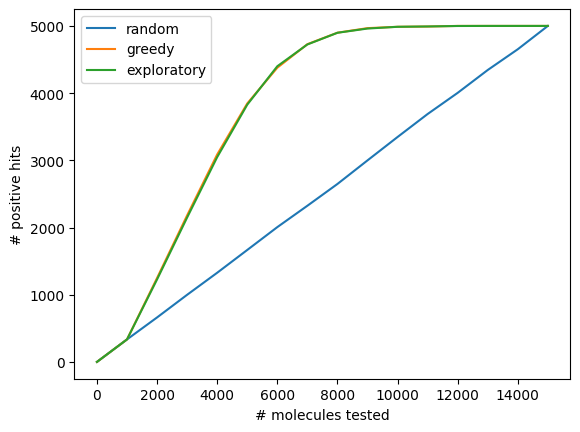

In [ ]:
plot_comparisons(
    random=random_batches,
    greedy=greedy_batches,
    exploratory=exploratory_batches,
)

## Load Data set #2

In [ ]:
# Download files from Google Drive to the notebook runtime.
filename_to_id = {
    "df197k_inactive_fingerprints.csv": "1PYbyVkCRMHF-dO_l32zb4g4g0Ln6srzF",
    "df417_active_fingerprints.csv": "1JY81_rwtJXcjQh4SyOJ6PQ6Xc033Egv5",
    "df78_active_fingerprints.csv": "1xgaMbvfQDjTxuOr7_uqsvQeNG0N6OIvo",
}
for filename, drive_id in filename_to_id.items():
    drive.CreateFile({"id": drive_id}).GetContentFile(filename)

In [ ]:
import pandas as pd
inactive_df = pd.read_csv("df197k_inactive_fingerprints.csv", header=0)
active_tested_df = pd.read_csv("df417_active_fingerprints.csv", header=0)
active_known_df = pd.read_csv("df78_active_fingerprints.csv", header=0)

In [ ]:
inactive_df

,Name,SMILES,ROUND1,ROUND2,ROUND3,ROUND4,bit0,bit1,bit2,bit3,...,bit1014,bit1015,bit1016,bit1017,bit1018,bit1019,bit1020,bit1021,bit1022,bit1023
0,BIOA-BRD-K77793136-003-02-2,O=C1NC=Cc2c1cccc2S(=O)(=O)N1CCC[NH2+]CC1,-,-,-,-,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,BIOA-BRD-K45296539-003-01-0,COCCNC(=O)COc1ccc(cc1)OCC[NH2+]C[C@@H](O)COc1c...,-,-,-,-,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,BIOA-BRD-K05528470-305-01-4,Clc1ccc(cc1)N1CC[NH+](CC1)CC1=CN=C2NC=CC=C12,-,-,-,-,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BIOA-BRD-K41143549-003-01-6,NC(=O)C[NH2+]CCC(c1ccccc1)c1ccccc1,-,-,-,-,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BIOA-BRD-K00312224-001-03-8,CCCc1c(nn(c1-c1ccc(cc1)O)-c1ccc(cc1)O)-c1ccc(c...,-,-,-,-,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197392,Z872348088,CN(C)c1ccc2cc(ccc2n1)NC(=O)c1cccc2cccnc12,-,-,-,-,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197393,BRD-K59310169-001-09-6,COc1ccc(c(c1)O)-c1cn[nH]c1-c1ccccc1OC,-,-,-,-,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197394,BRD-K00063208-001-01-9,CN(C)c1nc2c(s1)CN(CC2)c1ccc(cn1)C(F)(F)F,-,-,-,-,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197395,BRD-K97010173-001-06-9,Oc1ccccc1-c1nc(n(n1)-c1ccc(cc1)C(=O)[O-])-c1cc...,-,-,-,-,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
active_tested_df

,Unnamed: 0,Name,SMILES,ROUND1,ROUND2,ROUND3,ROUND4,bit0,bit1,bit2,...,bit1014,bit1015,bit1016,bit1017,bit1018,bit1019,bit1020,bit1021,bit1022,bit1023
0,0,BIOA-BRD-K01826923-001-01-9,COc1cccc2c1C(=O)c1c(c3c(c(c1C2=O)O)C[C@](O)(C[...,AT1,-,-,-,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,BIOA-BRD-K73191876-001-04-7,Oc1ccc2c(c1O)C(=O)c1ccccc1C2=O,AT2,-,-,-,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,BIOA-BRD-K97139501-001-03-3,COc1cccc(c1O)O,AT1,-,-,-,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,BIOA-BRD-K00317371-001-01-2,OCc1ccc(s1)-c1ccc(o1)-c1ccc(s1)CO,AT1,-,-,-,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,BIOA-BRD-K20742498-003-01-1,COc1cc(cc(c1)OC)COc1cc(c(cc1C(=O)CC[C@H]1CC[NH...,AT1,-,-,-,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,412,REPO-BRD-K58685305-001-20-4,Cc1cc(c2c(c1)C(=O)c1cc(cc(c1C2=O)O)[O-])O,AT1,AT2,-,-,0,0,0,...,0,0,0,0,0,0,0,0,0,0
413,413,REPO-BRD-K12106308-003-01-9,CCCCOc1ccc(cc1)CC/C=C/1\SC(=O)N(CC[NH3+])C1=O,AT1,-,-,-,0,0,0,...,0,0,0,0,0,0,1,0,0,0
414,414,REPO-BRD-K15025317-001-17-7,Cc1ccc(cc1)S(=O)(=O)/C=C/C#N,AT1,AT2,-,-,0,0,0,...,0,0,0,0,0,0,0,0,0,0
415,415,REPO-BRD-K59469039-001-09-8,CC(C)(C)c1cc(cc(c1O)C(C)(C)C)/C=C(\C#N)C(=S)N,AT1,-,-,-,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
active_known_df

,Unnamed: 0,Name,SMILES,ACTIVITY,ann1,ann2,ann3,bit0,bit1,bit2,...,bit1014,bit1015,bit1016,bit1017,bit1018,bit1019,bit1020,bit1021,bit1022,bit1023
0,0,10f-R,Cc1cc(sc1C(=O)N[C@@H](CCCNC(=[NH2+])N)C(=O)[O-...,+,enantiomer unknown,noknown,noknown,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,1,10f-S,Cc1cc(sc1C(=O)N[C@@H](CCCNC(=[NH2+])N)C(=O)[O-...,+,noknown,0 inactive,? Unknown,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,2,AmPip5,O=C(CCc1cccnc1)N1CC[C@H](CC1)NC(=O)C(c1ccccc1)...,-,noknown,noknown,noknown,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,3,AmPip6,Clc1ccc(cc1)C(C(=O)N[C@H]1CCN(CC1)C(=O)CCc1ccc...,-,noknown,noknown,noknown,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,4,BR103,Cc1[nH]c(nc1C(=O)N[C@@H](CCCNC(=[NH2+])N)C(=O)...,+,noknown,noknown,noknown,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,73,SB280936,NC(=[NH2+])NCCC[C@H](NC(=O)CN(Cc1cc(cc(c1)Cl)C...,-,noknown,noknown,noknown,0,1,0,...,0,0,0,0,0,0,0,0,0,0
74,74,SB290157,NC(=[NH2+])NCCC[C@H](NC(=O)COCC(c1ccccc1)c1ccc...,-,noknown,noknown,noknown,0,1,0,...,0,0,0,0,0,0,0,0,0,0
75,75,SC214-R,O=C(CCc1cccnc1)N1CC[C@H](CC1)NC(=O)[C@H]([C@H]...,+,noknown,noknown,noknown,0,1,1,...,0,0,0,0,0,1,0,0,0,0
76,76,SC214-S,O=C(CCc1cccnc1)N1CC[C@H](CC1)NC(=O)[C@@H]([C@H...,+,noknown,noknown,noknown,0,1,1,...,0,0,0,0,0,1,0,0,0,0


Convert dataframes to PyTorch.

In [ ]:
feature_cols = [f"bit{i}" for i in range(1024)]
def to_tensor(df):
    return torch.tensor(df[feature_cols].to_numpy(), dtype=torch.float)
inactive_features = to_tensor(inactive_df)
active_tested_features = to_tensor(active_tested_df)
active_known_features = to_tensor(active_known_df)

Merge the three data sources.

In [ ]:
features = torch.cat([active_known_features, active_tested_features, inactive_features])
K = len(active_known_features)
T = len(active_tested_features)
I = len(inactive_features)
true_labels = torch.cat([torch.ones(K + T), torch.zeros(I)])

Randomly shuffle data for our simulated experiment. We'll keep the known labels first because they were known before the experiment started. Then we'll shuffle the inactive and active tested features to simulate further data acquisition.

In [ ]:
torch.manual_seed(20211018)
perm = torch.cat([torch.arange(K), K + torch.randperm(T + I)])

features = features[perm]
true_labels = true_labels[perm]

## Active learning pipeline

In [ ]:
random_batches = active_learn(RandomModel, batch_size=4000, num_batches=10)

Found 87 positives
Found 99 positives
Found 111 positives
Found 120 positives
Found 128 positives
Found 133 positives
Found 138 positives
Found 145 positives
Found 159 positives
Found 170 positives


In [ ]:
%%time
greedy_batches = active_learn(GreedyMLP, batch_size=4000, num_batches=10)

Found 87 positives
Found 123 positives
Found 131 positives
Found 142 positives
Found 148 positives
Found 164 positives
Found 175 positives
Found 197 positives
Found 214 positives
Found 228 positives
CPU times: user 3min 21s, sys: 35.5 s, total: 3min 56s
Wall time: 3min 6s


In [ ]:
%%time
exploratory_batches = active_learn(
    ExploratoryMLP, thompson_batch_size=100, batch_size=4000, num_batches=10
)

Found 87 positives
........................................Found 103 positives
........................................Found 121 positives
........................................Found 129 positives
........................................Found 133 positives
........................................Found 138 positives
........................................Found 144 positives
........................................Found 150 positives
........................................Found 160 positives
........................................Found 172 positives
CPU times: user 13min 45s, sys: 3min 24s, total: 17min 10s
Wall time: 12min 10s


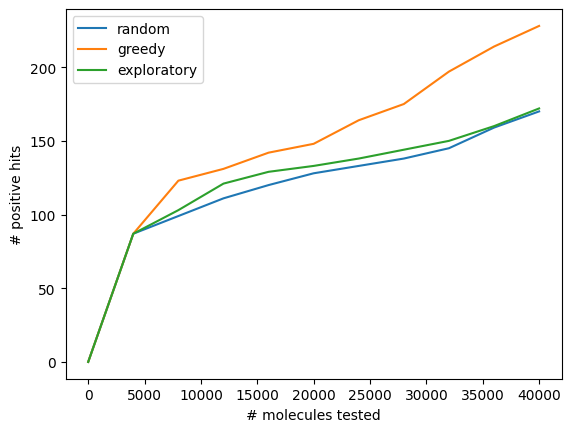

In [ ]:
plot_comparisons(
    random=random_batches,
    greedy=greedy_batches,
    exploratory=exploratory_batches,
)